# Automaton Benchmark – Result Analysis

This notebook loads the CSV produced by `run_tests.py`, cleans and aggregates the
data, and visualises how the three main input variables

* **count** (number of atomic formulas combined by AND/OR)
* **depth** (quantifier depth)
* **constant** (right-hand-side value *c*)

affect the two outputs

* **time_ms**
* **num_states**

`time_ms == 10 000` indicates the run hit the 10-second timeout.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 🔧 Adjust if your file is elsewhere
CSV_PATH = Path("test_results/test_results.csv")

# Load raw results
df_raw = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df_raw)} rows")
df_raw.head()

Loaded 1830 rows


,expression,count,constant,variable_count,depth,mode,time_ms,num_states
0,(A a. E b. 2a -3b +3c = 0),1,0,3,2,random,4.646875,1.0
1,(A a. E b. -2a -2b -2c -3d -2e < 0),1,0,5,2,random,11.507167,1.0
2,(A a. E b. A c. E d. 3a -1b -2c +3d +1e <= 0),1,0,5,4,random,7.020750,1.0
3,(A a. E b. 2a +2b -1c -1d -1e -3f +3g > 0),1,0,7,2,random,49.015666,1.0
4,(A a. E b. A c. E d. 2a -3b +2c -3d -1e -3f -3...,1,0,7,4,random,427.301292,1.0


In [15]:
# Replace "n/a" in runtime with the timeout value (10 000 ms) and cast to float
df_raw["time_ms"] = (
    df_raw["time_ms"]
    .replace("n/a", 10_000)
    .astype(float)
)

# Convert num_states, coercing errors to NaN (these rows timed-out / failed)
df_raw["num_states"] = pd.to_numeric(df_raw["num_states"], errors="coerce")

print(df_raw.isna().sum())
df_raw.head()

expression          0
count               0
constant            0
variable_count      0
depth               0
mode                0
time_ms           385
num_states        385
dtype: int64


,expression,count,constant,variable_count,depth,mode,time_ms,num_states
0,(A a. E b. 2a -3b +3c = 0),1,0,3,2,random,4.646875,1.0
1,(A a. E b. -2a -2b -2c -3d -2e < 0),1,0,5,2,random,11.507167,1.0
2,(A a. E b. A c. E d. 3a -1b -2c +3d +1e <= 0),1,0,5,4,random,7.020750,1.0
3,(A a. E b. 2a +2b -1c -1d -1e -3f +3g > 0),1,0,7,2,random,49.015666,1.0
4,(A a. E b. A c. E d. 2a -3b +2c -3d -1e -3f -3...,1,0,7,4,random,427.301292,1.0


In [17]:
group_cols = ["count", "constant", "variable_count", "depth", "mode"]

# Average runtime (include all rows, even 10 000 ms ones)
df_time = df_raw.groupby(group_cols, as_index=False)["time_ms"].mean()

# Average num_states (exclude runs that failed → NaN)
df_states = (
    df_raw
    .dropna(subset=["num_states"])
    .groupby(group_cols, as_index=False)["num_states"]
    .mean()
)

# Merge the two
df = pd.merge(df_time, df_states, on=group_cols, how="left")
print(f"Aggregated down to {len(df)} rows")
df.head()

Aggregated down to 390 rows


,count,constant,variable_count,depth,mode,time_ms,num_states
0,1,0,3,2,random,4.646875,1.0
1,1,0,5,2,random,11.507167,1.0
2,1,0,5,4,random,7.020750,1.0
3,1,0,7,2,random,49.015666,1.0
4,1,0,7,4,random,427.301292,1.0


In [18]:
def plot_metric_vs_var(df, xvar, metric, title_suffix=""):
    """
    Aggregate by `xvar` alone and make a simple line plot of `metric`.
    """
    series = df.groupby(xvar)[metric].mean()
    plt.figure()
    series.plot(marker="o")
    plt.title(f"{metric} vs {xvar} {title_suffix}".strip())
    plt.xlabel(xvar)
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

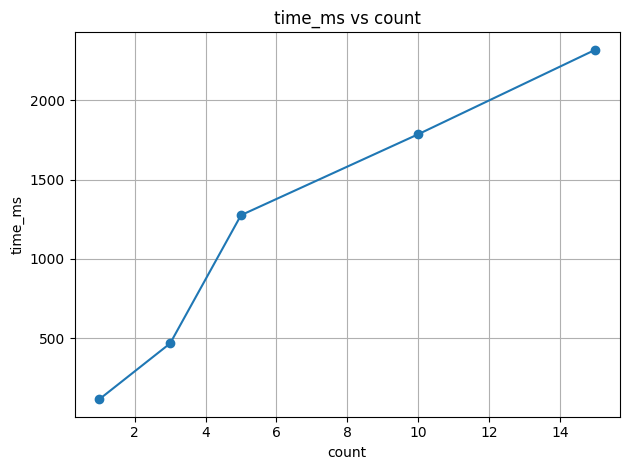

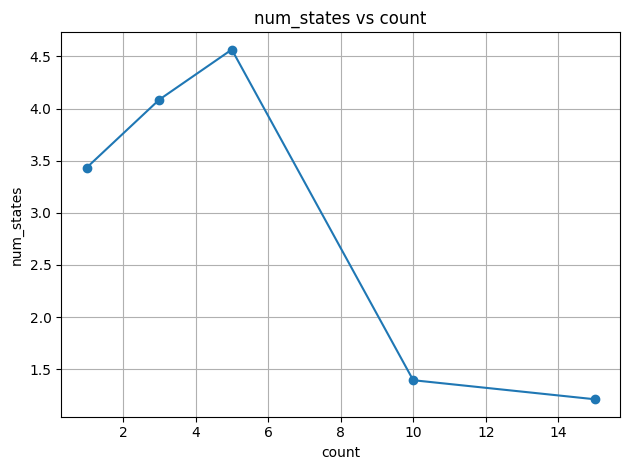

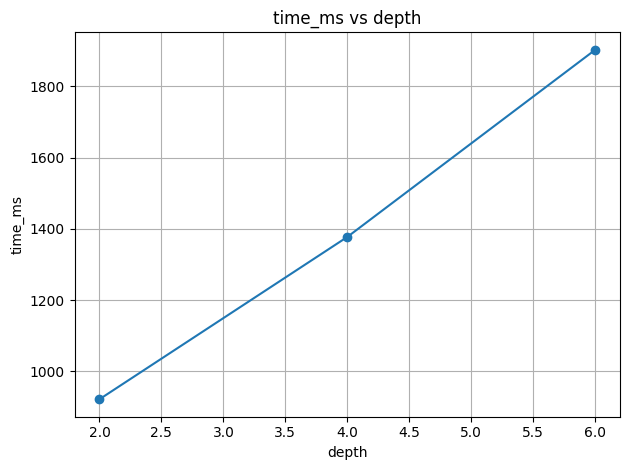

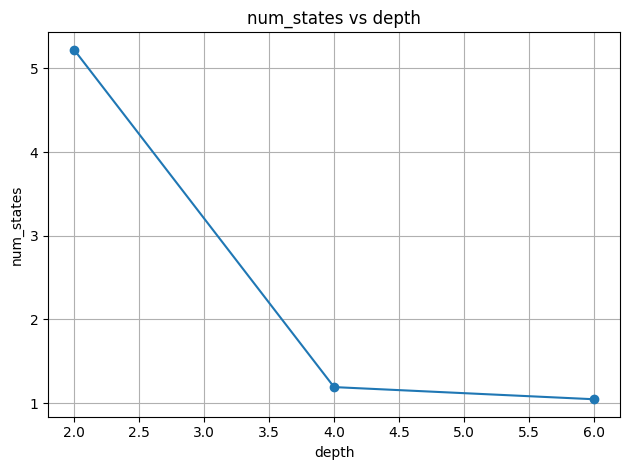

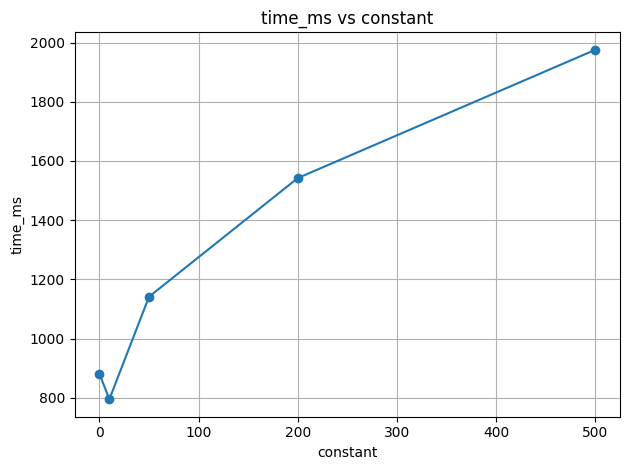

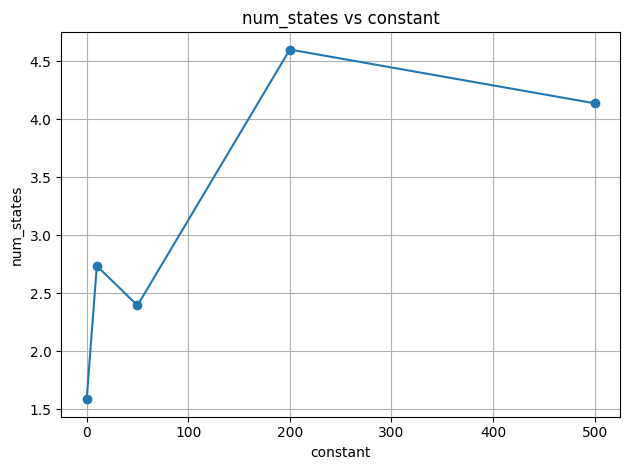

In [19]:
for var in ["count", "depth", "constant"]:
    plot_metric_vs_var(df, var, "time_ms")
    plot_metric_vs_var(df, var, "num_states")

### Observations

* *Fill in your notes here after looking at the plots.*

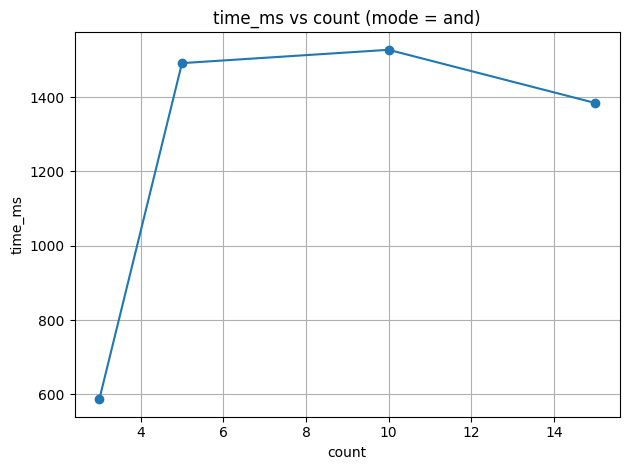

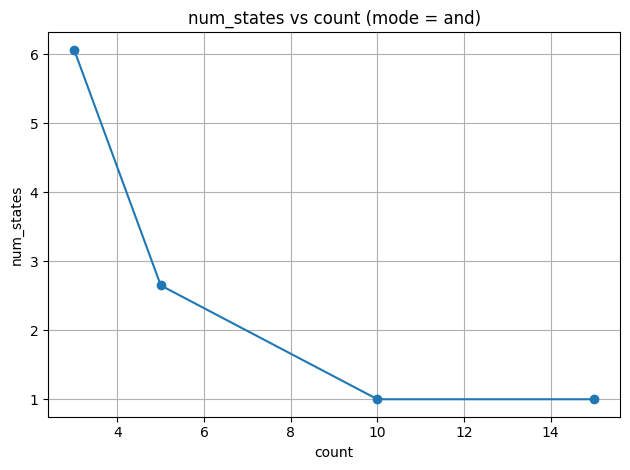

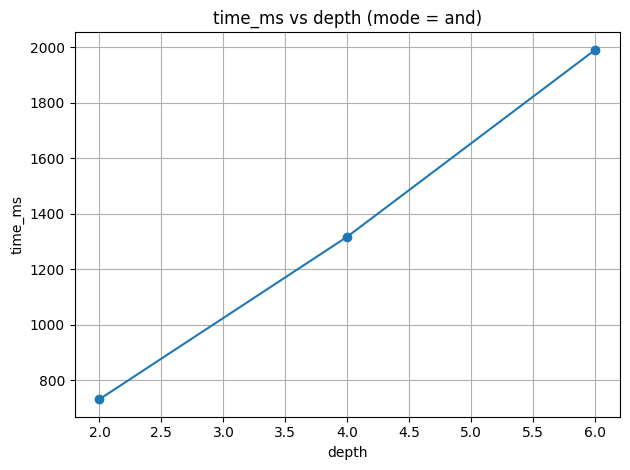

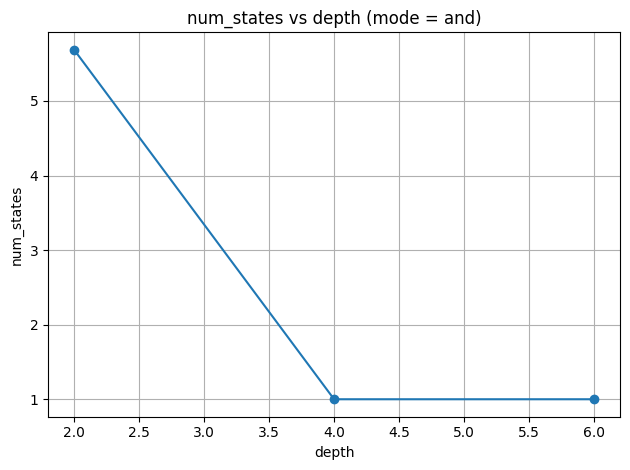

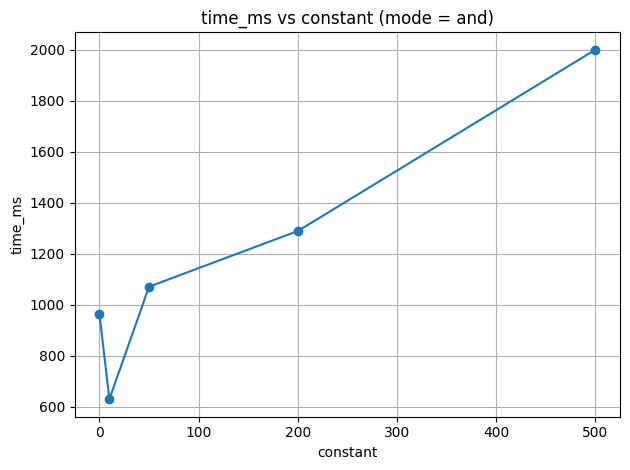

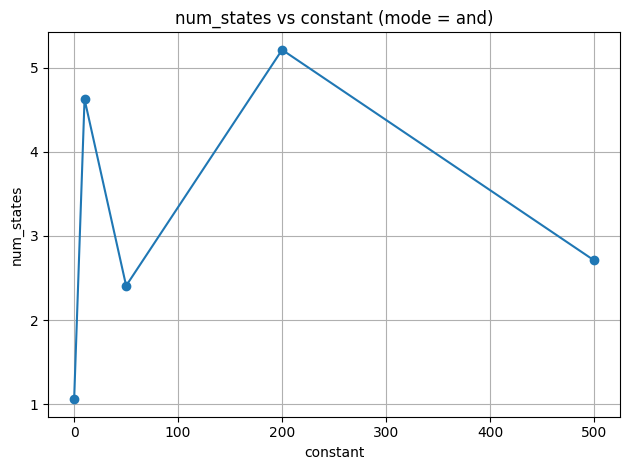

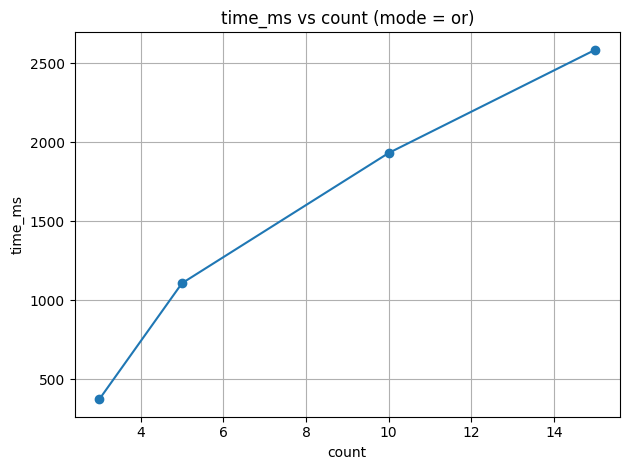

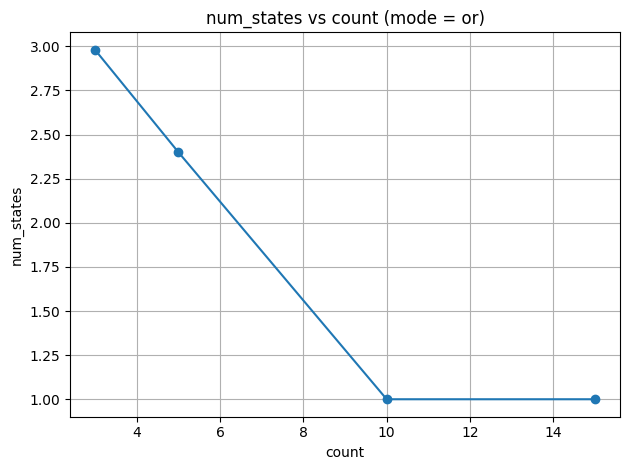

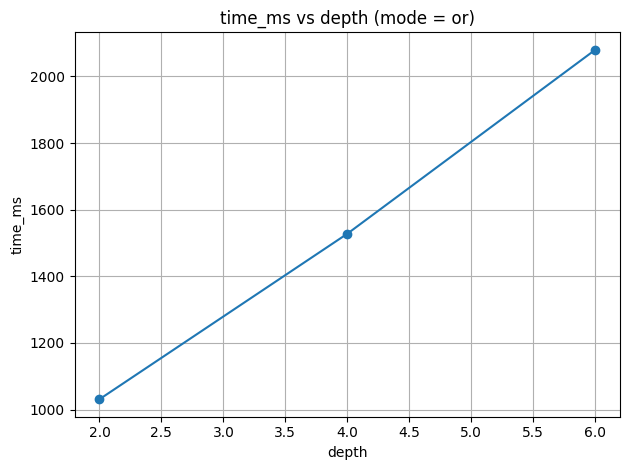

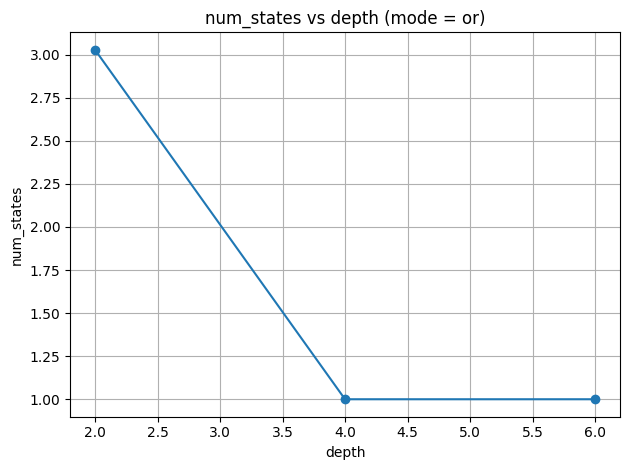

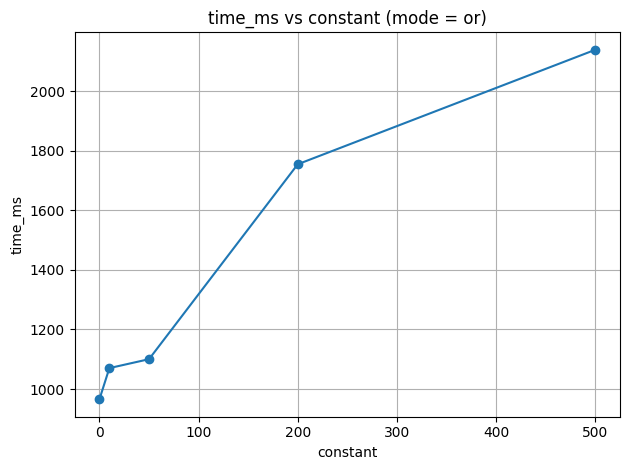

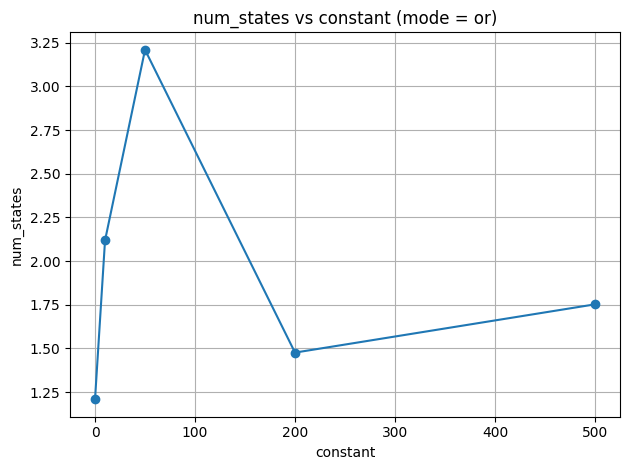

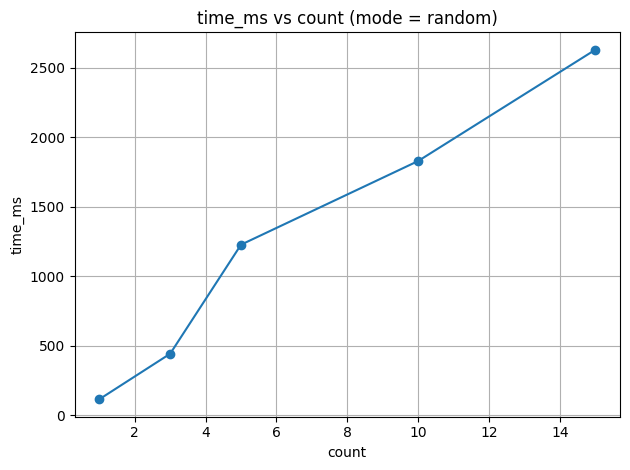

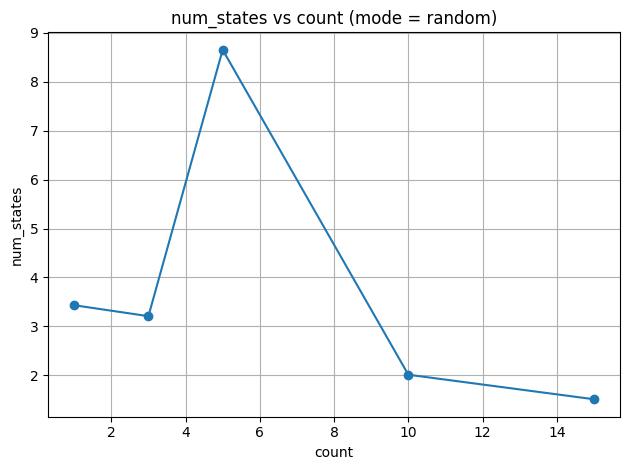

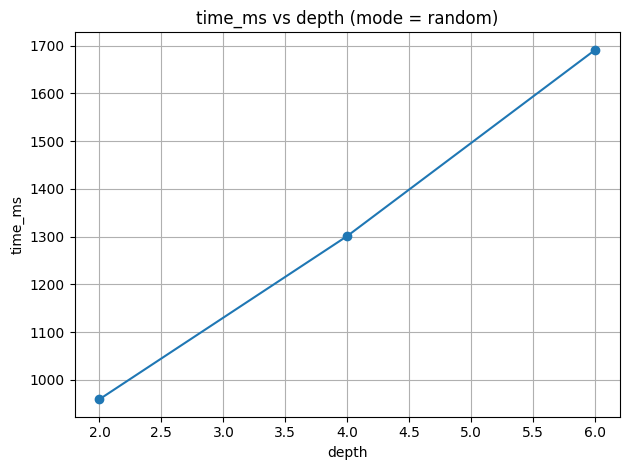

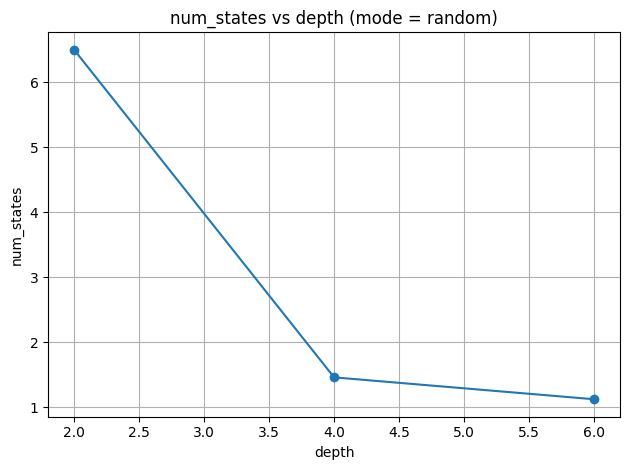

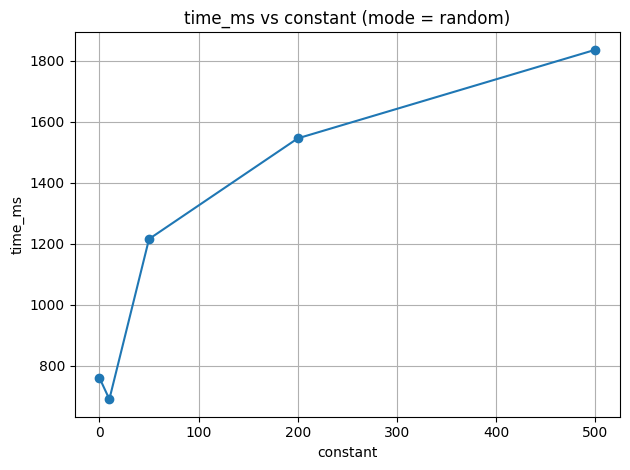

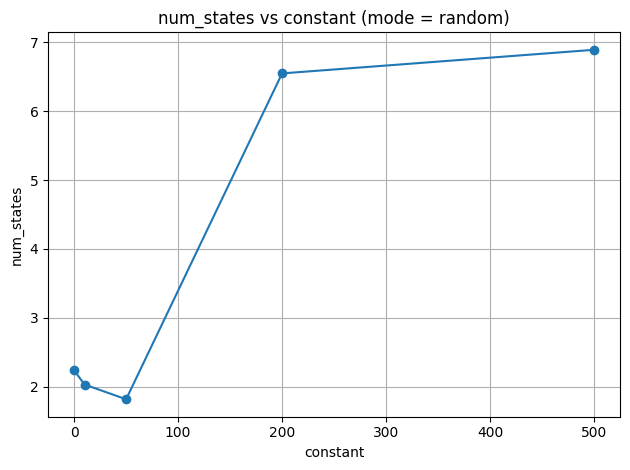

In [20]:
for m in ["and", "or", "random"]:
    sub = df[df["mode"] == m]
    for var in ["count", "depth", "constant"]:
        plot_metric_vs_var(sub, var, "time_ms", f"(mode = {m})")
        plot_metric_vs_var(sub, var, "num_states", f"(mode = {m})")

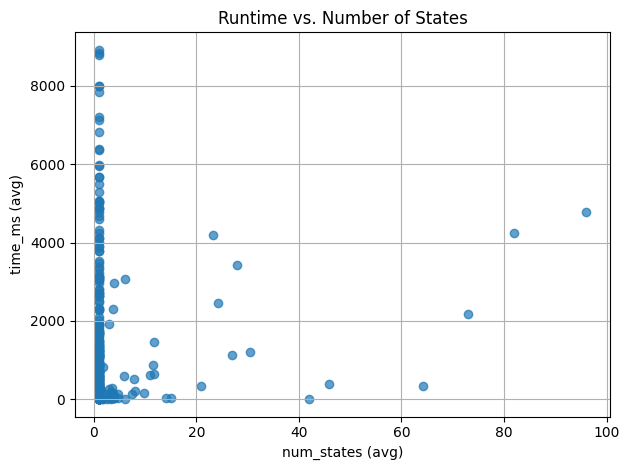

In [21]:
plt.figure()
plt.scatter(
    df["num_states"],
    df["time_ms"],
    alpha=0.7,
    label="all modes"
)
plt.xlabel("num_states (avg)")
plt.ylabel("time_ms (avg)")
plt.title("Runtime vs. Number of States")
plt.grid(True)
plt.tight_layout()
plt.show()

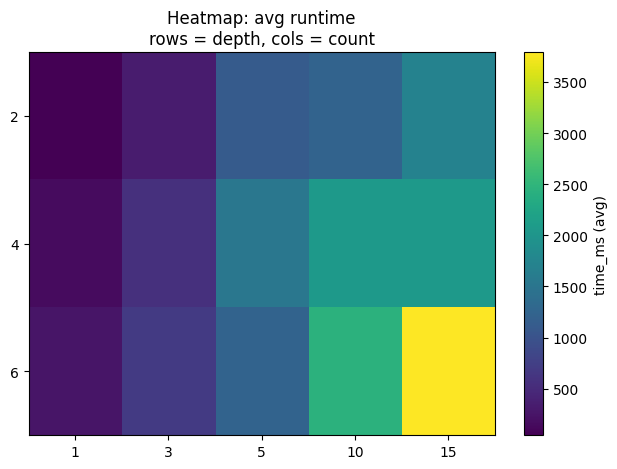

In [22]:
pivot = df.pivot_table(
    index="depth",
    columns="count",
    values="time_ms",
    aggfunc="mean"
)

plt.figure()
plt.imshow(pivot, aspect="auto")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.colorbar(label="time_ms (avg)")
plt.title("Heatmap: avg runtime\nrows = depth, cols = count")
plt.tight_layout()
plt.show()

## Key Take-aways

* Bullet-point your findings here.
* Which parameters blow up the state space?
* Where does runtime saturate regardless of state count?

## Further Exploration

* Try log-scaling the `time_ms` axis for better separation.
* Slice by `variable_count`.
* Add regression / curve-fit for growth rates.